<a href="https://colab.research.google.com/github/drdogangurkan/project1/blob/main/EDRASNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook contains the coding of the EDRASNet model developed by [Gürkan DOĞAN](https://scholar.google.ca/citations?user=SW4p1d4AAAAJ&hl=tr&oi=ao) for the detection of drivable road areas.**

In [ ]:
#Drive daki dosyalara erişmek için izin verir.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#ilgili calisma klasorune gecer.
import os
os.chdir("/content/drive/My Drive/COLAB_CALISMALARIM/CALISMA_7_Drivable_Road_Region")

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
!nvidia-smi

Sat Dec 31 12:34:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)

In [ ]:
import os
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import normalize
import glob
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU,Input,AveragePooling2D, Activation, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, MaxPool2D
from tensorflow.keras.layers import Lambda,GlobalMaxPooling2D, DepthwiseConv2D, Reshape, Permute, Add, concatenate, Concatenate, Multiply


from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU 
from tensorflow.keras import backend as K
import time

In [ ]:
import os
import cv2
from tqdm import tqdm
from glob import glob
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import albumentations as A

In [ ]:
print(tf.executing_eagerly())

True


#DATA Preparation and Loading

In [ ]:
tr = np.load('CamVid_Data/binary_camvid_256_train_set.npz', allow_pickle=True)
vl = np.load('CamVid_Data/binary_camvid_256_validation_set.npz', allow_pickle=True)
ts = np.load('CamVid_Data/binary_camvid_256_test_set.npz', allow_pickle=True)

In [ ]:
print(tr.files)
print(vl.files)
print(ts.files)

['tr_image', 'tr_mask']
['vl_image', 'vl_mask']
['ts_image', 'ts_mask']


In [ ]:
#isimlere göre np.array cagrilir.
tr_img = tr['tr_image']
tr_lbl = tr['tr_mask']

vl_img = vl['vl_image']
vl_lbl = vl['vl_mask']

ts_img = ts['ts_image']
ts_lbl = ts['ts_mask']

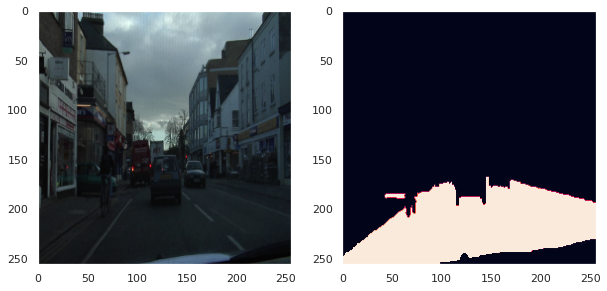

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.grid(False)
plt.imshow((tr_img[42]))
plt.subplot(1, 2, 2)
plt.grid(False)
plt.imshow(tr_lbl[42])

In [ ]:
tr_lbl[42]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [ ]:
np.unique(tr_lbl)

array([0, 1])

In [ ]:
tr_image = np.array(tr_img , dtype='float32')
tr_mask = np.array(tr_lbl , dtype= 'float32')

ts_image = np.array(ts_img , dtype='float32')
ts_mask = np.array(ts_lbl , dtype= 'float32')

vl_image = np.array(vl_img , dtype='float32')
vl_mask = np.array(vl_lbl , dtype= 'float32')

print(tr_image.shape, tr_mask.shape)
print(ts_image.shape, ts_mask.shape)
print(vl_image.shape, vl_mask.shape)

(367, 256, 256, 3) (367, 256, 256)
(233, 256, 256, 3) (233, 256, 256)
(101, 256, 256, 3) (101, 256, 256)


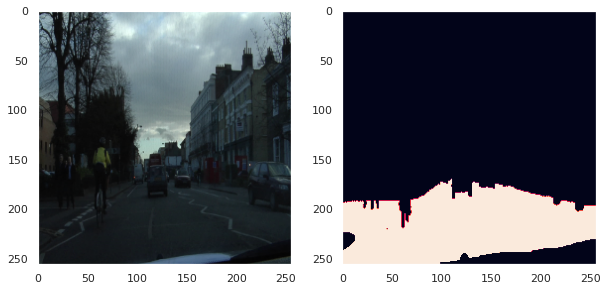

In [ ]:
image_num = 23
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.grid(False)
plt.imshow((tr_image[image_num])/255)
plt.subplot(1, 2, 2)
plt.grid(False)
plt.imshow(tr_mask[image_num])

In [ ]:
tr_mask = np.expand_dims(tr_mask, axis = 3)
ts_mask = np.expand_dims(ts_mask, axis = 3)
vl_mask = np.expand_dims(vl_mask, axis = 3)

In [ ]:
print(tr_image.shape, tr_mask.shape)
print(ts_image.shape, ts_mask.shape)
print(vl_image.shape, vl_mask.shape)

(367, 256, 256, 3) (367, 256, 256, 1)
(233, 256, 256, 3) (233, 256, 256, 1)
(101, 256, 256, 3) (101, 256, 256, 1)


normalization

In [ ]:
tr_image= tr_image / 255.0
ts_image = ts_image / 255.0
vl_image = vl_image / 255.0

loses

In [ ]:
#losses
def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

def jaccard_coef(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    """y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = tf.cast(y_pred_f, tf.float32)"""
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jaccard_coef_loss(y_true, y_pred):
    return 1.0 - jaccard_coef(y_true, y_pred)

def dice_coef(y_true, y_pred):
    #y_true = tf.cast(y_true, y_pred.dtype)
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
 
    return 1.0 - dice_coef(y_true, y_pred)

#Hiperparameters

In [ ]:
EPOCH = 100

#Proposed MODEL

In [ ]:
#AConv Block
def convolution_block(block_input, num_filters=128, kernel_size=3, dilation_rate=1,padding="same",use_bias=False):
  x = Conv2D(
      num_filters,
      kernel_size=kernel_size,
      dilation_rate=dilation_rate,
      padding="same",
      use_bias=use_bias,
      kernel_initializer=keras.initializers.HeNormal()
  )(block_input)
  x = BatchNormalization()(x)
  return tf.nn.relu(x)


In [ ]:
#Max Pooling Block
def max_pool_block(dspp_input,n_filters, _name=''):
  conv = tf.keras.layers.Conv2D(filters=n_filters,kernel_size=(3,1), kernel_initializer='he_normal', padding='same', name='GDASPP_MP_Block'+str(_name)+'_Conv1')(dspp_input)
  conv = tf.keras.layers.Conv2D(filters=n_filters,kernel_size=(1,3), kernel_initializer='he_normal', padding='same', name='GDASPP_MP_Block'+str(_name)+'_Conv2')(conv)
  conv = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='GDASPP_MP_Block'+str(_name)+'_max_pooling1')(conv)
  conv = tf.keras.layers.BatchNormalization(name='GDASPP_MP_Block'+str(_name)+'_batchNorm1')(conv)
  return tf.nn.relu(conv, name='GDASPP_MP_Block'+str(_name)+'_relu1')

In [ ]:
#Avg Pooling Block
def avg_pool_block(dspp_input,n_filters, _name=''):
  conv = tf.keras.layers.Conv2D(filters=n_filters,kernel_size=(3,1), kernel_initializer='he_normal', padding='same', name='GDASPP_AP_Block'+str(_name)+'_Conv1')(dspp_input)
  conv = tf.keras.layers.Conv2D(filters=n_filters,kernel_size=(1,3), kernel_initializer='he_normal', padding='same', name='GDASPP_AP_Block'+str(_name)+'_Conv2')(conv)
  conv = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), name='GDASPP_AP_Block'+str(_name)+'_max_pooling1')(conv)
  conv = tf.keras.layers.BatchNormalization(name='GDASPP_AP_Block'+str(_name)+'_batchNorm1')(conv)
  return tf.nn.relu(conv, name='GDASPP_AP_Block'+str(_name)+'_relu1')

In [ ]:
def upsample_block_2(dspp_input, _size, _name=''):
  return UpSampling2D(size=(_size, _size), interpolation="bilinear", name='GDASPP_UpSampling'+str(_name))(dspp_input)

In [ ]:
#Asymmetric Convolution (AConv) Block 
def convolution_block_2(block_input, n_filters=128, kernel_size=3, dilation_rate=1,padding="same",use_bias=False, _name=''):
  ks1, ks2, ks3, ks4 = kernel_size, 1, 1, kernel_size
  x = Conv2D(
      n_filters,
      kernel_size=(ks1, ks2),
      dilation_rate=dilation_rate,
      padding="same",
      use_bias=use_bias,
      kernel_initializer=keras.initializers.HeNormal(),
      name=str(_name)+'_Conv1'
  )(block_input)
  x = Conv2D(
      n_filters,
      kernel_size=(ks3, ks4),
      dilation_rate=dilation_rate,
      padding="same",
      use_bias=use_bias,
      kernel_initializer=keras.initializers.HeNormal(),
      name=str(_name)+'_Conv2'
  )(x)
  x = BatchNormalization(name=str(_name)+'_batchNorm1')(x)
  return tf.nn.relu(x,name=str(_name)+'_relu1')

In [ ]:
#Attentional atrous spatial pyramid pooling (AASPP) module
def AASPP(dspp_input, n_filters):

    dims = dspp_input.shape
    #---------------MSAC Module--------------#
    out_1 = tf.keras.layers.Conv2D(filters=n_filters,kernel_size=(1,1), kernel_initializer='he_normal', padding='same', name='GDASPP_Conv_Block1')(dspp_input)
    out_6 = convolution_block_2(dspp_input,n_filters/2, kernel_size=3, dilation_rate=6, _name='GDASPP_Conv_Block2')
    out_12 = convolution_block_2(dspp_input,n_filters/2, kernel_size=3, dilation_rate=12, _name='GDASPP_Conv_Block3')
    out_18 = convolution_block_2(dspp_input,n_filters/2, kernel_size=3, dilation_rate=18, _name='GDASPP_Conv_Block4')
    #---------------MSAC Module--------------#

    #---------------DSSA Module--------------#
    avg_pool_1 = avg_pool_block(dspp_input,n_filters, _name='1')
    avg_pool_2 = avg_pool_block(avg_pool_1,n_filters/2, _name='2')
    #channel shuffle
    avg_pool_2 = channel_shuffle(avg_pool_2,2)

    max_pool_1 = max_pool_block(dspp_input,n_filters, _name='1')
    max_pool_2 = max_pool_block(max_pool_1,n_filters/2, _name='2')
    #channel shuffle
    max_pool_2 = channel_shuffle(max_pool_2,2)

    con_1 = tf.keras.layers.Concatenate(axis=3)([avg_pool_1,max_pool_1])
    con_2 = tf.keras.layers.Concatenate(axis=3)([avg_pool_2,max_pool_2])
    #Sigmoid Block-1
    sig_1 = tf.keras.layers.Conv2D(filters=1,kernel_size=(5,1), activation='sigmoid', kernel_initializer='he_normal', padding='same', use_bias=False, name='GDASPP_Conv2d1_1')(con_1)
    sig_1 = tf.keras.layers.Conv2D(filters=1,kernel_size=(1,5), activation='sigmoid', kernel_initializer='he_normal', padding='same', use_bias=False, name='GDASPP_Conv2d1_2')(sig_1)
    #Sigmoid Block-2
    sig_2 = tf.keras.layers.Conv2D(filters=1,kernel_size=(5,1), activation='sigmoid', kernel_initializer='he_normal', padding='same', use_bias=False, name='GDASPP_Conv2d2_1')(con_2)
    sig_2 = tf.keras.layers.Conv2D(filters=1,kernel_size=(1,5), activation='sigmoid', kernel_initializer='he_normal', padding='same', use_bias=False, name='GDASPP_Conv2d2_2')(sig_2)

    mul_1 = tf.keras.layers.Multiply()([con_1, sig_1])
    mul_2 = tf.keras.layers.Multiply()([con_2, sig_2])

    up_1 = upsample_block_2(mul_1, 2, _name='1')
    up_2 = upsample_block_2(mul_2, 4, _name='2')
    up_N = Concatenate(axis=-1)([up_1, up_2])
    #---------------DSSA Module--------------#
    x = Concatenate(axis=-1)([up_N, out_1, out_6, out_12, out_18])
    con_4 = convolution_block_2(x, kernel_size=1, _name='GDASPP_Conv_Block5')

    return con_4

In [ ]:
def conv2d(block_input, num_filters=128, kernel_size=3, stride=1, dilation_rate=1,padding="same",use_bias=False):
  x = Conv2D(
      num_filters,
      kernel_size=kernel_size,
      strides = stride,
      dilation_rate=dilation_rate,
      padding="same",
      use_bias=use_bias,
      kernel_initializer=keras.initializers.HeNormal()
  )(block_input)
  return x

In [ ]:
#DWConv Block
def DWConv2d(block_input, kernel_size=3, strides = (1,1), dilation_rate=1, padding="same", depth_multiplier=1, use_bias=True):
  x = DepthwiseConv2D(
      kernel_size =  kernel_size,
      strides = strides,
      padding = padding,
      depth_multiplier=depth_multiplier,
      data_format=None,
      dilation_rate=dilation_rate,
      activation=None,
      use_bias=use_bias,
      depthwise_initializer='glorot_uniform'
  )(block_input)
  return x

In [ ]:
def channel_shuffle(x, groups):
    _, width, height, channels = x.get_shape().as_list()
    group_ch = channels // groups
    x = Reshape([width, height, group_ch, groups])(x)
    x = Permute([1, 2, 4, 3])(x)
    x = Reshape([width, height, channels])(x)
    return x

In [ ]:
#Effective residual asymmetric (ERA) block
def ERAB(_x, groups, dilated_rate, n_filters):
  #NOT:3x1 ve 1x3 conv islemleri art arda yapilirsa 3x3 conv islemine denk gelir 
  #ancak islem sayisi direkt 3x3 conv a göre azaltilir. Bu islem soerable convolution olarak gecer.

  #3x1 Kernel Conv
  x_1 = conv2d(_x, num_filters=n_filters, kernel_size=(3,1), dilation_rate=1, padding="same",use_bias=True)
  #1x3 Kernel Conv
  x_1 = conv2d(x_1, num_filters=n_filters, kernel_size=(1,3), dilation_rate=1, padding="same",use_bias=True)
  #batch norm. and relu
  x_1 = BatchNormalization()(x_1)
  x_1 = tf.nn.relu(x_1)

  #channel shuffle
  x_ch = channel_shuffle(x_1,groups)

  #3x1 DWConv
  x_dw = DWConv2d(x_ch, kernel_size=(3,1), strides = (1,1), dilation_rate=1, padding="same", depth_multiplier=1, use_bias=True)
  #1x3 DWConv
  x_dw = DWConv2d(x_dw, kernel_size=(1,3), strides = (1,1), dilation_rate=1, padding="same", depth_multiplier=1, use_bias=True)
  #batch norm. and relu
  x_dw = BatchNormalization()(x_dw)
  x_dw = tf.nn.relu(x_dw)

  #3x1 Kernel Conv
  x_co = conv2d(x_ch, num_filters=n_filters, kernel_size=(3,1), dilation_rate = dilated_rate, padding="same",use_bias=True)
  #1x3 Kernel Conv
  x_co = conv2d(x_co, num_filters=n_filters, kernel_size=(1,3), dilation_rate = dilated_rate, padding="same",use_bias=True)
  #batch norm. and relu
  x_co = BatchNormalization()(x_co)
  x_co = tf.nn.relu(x_co)

  #Concatenate
  x_cnc = concatenate([x_dw,x_co], axis=3)

  #1x1 conv
  x_2 = conv2d(x_cnc, num_filters=n_filters, kernel_size=(1,1), dilation_rate=1, padding="same",use_bias=True)
  #batch norm. and relu
  x_2 = BatchNormalization()(x_2)
  x_2 = tf.nn.relu(x_2)

  #Add
  x_add = Add()([x_1, x_2])
  return x_add

In [ ]:
def downsample_block(x, groups, dilated_rate, n_filters):
   f = ERAB(x, groups=groups, dilated_rate=dilated_rate, n_filters=n_filters)
   p = MaxPool2D(2)(f)
   p = Dropout(0.3)(p)
   return f, p

In [ ]:
def upsample_block(x, groups, dilated_rate, conv_features, n_filters):
   # upsample
   x = Conv2DTranspose(n_filters, kernel_size=3, strides=2, padding="same", activation='relu')(x)
   # concatenate
   x = concatenate([x, conv_features])
   # dropout
   x = Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = ERAB(x, groups=groups, dilated_rate=dilated_rate, n_filters=n_filters)
   return x

In [ ]:
def proposed_model():  
  # inputs
  inputs = Input(shape=(256,256,3))
  # encoder: contracting path - downsample
  # 1 - downsample
  f1, p1 = downsample_block(inputs, groups=2, dilated_rate=2, n_filters=16)
  # 2 - downsample
  f2, p2 = downsample_block(p1, groups=2, dilated_rate=4, n_filters=32)
  # 3 - downsample
  f3, p3 = downsample_block(p2, groups=2, dilated_rate=8, n_filters=64)
  # 4 - downsample
  f4, p4 = downsample_block(p3, groups=2, dilated_rate=16, n_filters=96)
  # 5 - bottleneck
  #bottleneck = double_conv_block(p4, 512)
  #yeni blok, downsample blok 2 
  mp1 = MaxPooling2D(pool_size=(3,3), strides=2)(inputs)
  ap1 = AveragePooling2D(pool_size=(3,3), strides=2)(inputs)
  cn1 = concatenate([mp1, ap1], axis=3)
  cv1 = conv2d(cn1, num_filters=64, kernel_size=(3,3), stride=2, dilation_rate=1, padding="same",use_bias=True)
  cv1 = conv2d(cv1, num_filters=64, kernel_size=(3,3), stride=2, dilation_rate=1, padding="same",use_bias=True)
  cv1 = conv2d(cv1, num_filters=64, kernel_size=(3,3), stride=2, dilation_rate=1, padding="same",use_bias=True)

  bottleneck = AASPP(p4, 64)
  cn1 = concatenate([cv1, bottleneck], axis=3)
  # decoder: expanding path - upsample
  # 6 - upsample
  u6 = upsample_block(cn1, groups=1, dilated_rate=16, conv_features=f4, n_filters=96)
  # 7 - upsample
  u7 = upsample_block(u6, groups=1, dilated_rate=8, conv_features=f3, n_filters=64)
  # 8 - upsample
  u8 = upsample_block(u7, groups=1, dilated_rate=4, conv_features=f2, n_filters=32)
  # 9 - upsample
  u9 = upsample_block(u8, groups=1, dilated_rate=2, conv_features=f1, n_filters=16)
  # outputs
  outputs = Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
  # EDRASNet model with Keras Functional API
  model = tf.keras.Model(inputs, outputs, name="EDRASNet")
  return model

In [ ]:
proposed_model = proposed_model()
proposed_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  784         ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)
proposed_model.compile(optimizer=opt, 
              loss= dice_coef_loss,
              metrics=[jaccard_coef,dice_coef,'accuracy'])

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                         patience =10,
                         verbose = 1,
                         factor = 0.1,
                         min_lr = 0.00001)

mcp = ModelCheckpoint(filepath=r"model_hpo.h5", 
    save_weights_only=True,
    monitor='val_jaccard_coef',
    mode='auto',
    verbose=0,
    save_best_only=False)

In [ ]:
EPOCH = 100

In [ ]:
now = time.time()
history1 = proposed_model.fit(tr_image, tr_mask, batch_size=8, epochs=EPOCH, validation_data=(vl_image, vl_mask), shuffle=True, callbacks = [lrd , mcp])
end = time.time()
print('time: ', end - now)

Epoch 1/100
46/46 [==============================] - 36s 512ms/step - loss: 0.1585 - jaccard_coef: 0.7453 - dice_coef: 0.8418 - accuracy: 0.8963 - val_loss: 0.1790 - val_jaccard_coef: 0.7008 - val_dice_coef: 0.8228 - val_accuracy: 0.8991 - lr: 0.0100
Epoch 2/100
46/46 [==============================] - 19s 415ms/step - loss: 0.0591 - jaccard_coef: 0.8890 - dice_coef: 0.9410 - accuracy: 0.9637 - val_loss: 0.0871 - val_jaccard_coef: 0.8398 - val_dice_coef: 0.9126 - val_accuracy: 0.9486 - lr: 0.0100
Epoch 3/100
46/46 [==============================] - 19s 410ms/step - loss: 0.0473 - jaccard_coef: 0.9100 - dice_coef: 0.9527 - accuracy: 0.9708 - val_loss: 0.0955 - val_jaccard_coef: 0.8318 - val_dice_coef: 0.9064 - val_accuracy: 0.9458 - lr: 0.0100
Epoch 4/100
46/46 [==============================] - 19s 407ms/step - loss: 0.0453 - jaccard_coef: 0.9137 - dice_coef: 0.9547 - accuracy: 0.9721 - val_loss: 0.0432 - val_jaccard_coef: 0.9180 - val_dice_coef: 0.9572 - val_accuracy: 0.9760 - lr: 0.0